# Imports

In [ ]:
# !pip install pandas
# !pip install re
# !pip install string
# !pip install seaborn
# !pip install matplotlib
# !pip install textblob
# !pip install nltk
# !pip install tqdm
# !pip install spacy

In [1]:
import pandas as pd
import re
import string
import seaborn as sns
from matplotlib import pyplot as plt
from textblob import TextBlob
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Loading, Preprocessing and EDA

### Long Functions

In [2]:
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [3]:
def decontract(raw_html):
    for word in raw_html.split():
        if word.lower() in contractions:
            raw_html = raw_html.replace(word, contractions[word.lower()])
    return raw_html

### Load and Clean

In [ ]:
df = pd.DataFrame()
df['text'] = pd.read_csv('airline_sentiment_analysis.csv').drop('Unnamed: 0', axis=1).text
df['sentiment'] = pd.read_csv('airline_sentiment_analysis.csv').drop('Unnamed: 0', axis=1).airline_sentiment
# df

In [ ]:
unique_texts = list(set(df.text))

In [ ]:
df_new = pd.DataFrame(columns=['text', 'sentiment'])
for i in unique_texts:
    df_new = df_new.append(df[df.text == i].iloc[0])

In [ ]:
len(df.text), len(set(df.text)), len(df_new), len(df_new.text)

(11541, 11381, 11381, 11381)

In [ ]:
df = df_new.copy()

In [ ]:
set(df.sentiment)              # Sentiment classes - positive and negetive only no neutral category.

{'negative', 'positive'}

In [ ]:
# [print(i) for i in df.text]

In [ ]:
def simple_preprocessing_function(text):
    text = re.sub('@\S*\s','',text+str(' '))      # Removing @VirginAmerica and likes of that
    text = re.sub('http:\S*\s','',text+str(' '))  # Remove hyperlinks
    text = decontract(text)                       # Decontractions
    text = re.sub("[^-9A-Za-z ]", " " , text)     # Remove punctuations and special charaters
    text = re.sub(' +', ' ', text)                # Remove extra spaces
    text = "".join([i.lower() for i in text if i not in string.punctuation])  # To lower case
    return text

prep_text = []
for i in df.text:
    prep_text.append(simple_preprocessing_function(i))

df['text'] = prep_text

df['sentiment'] = list((df.sentiment=='positive')*1)     # This is simple binary categorical variable to no need of encoding
                                                        # 1 for positive, 0 for negetive

Now we want to see how much similar our labels are with textblob etc sentiment analyzers.

### Ratings by TextBlob and NLTK

In [ ]:
########## TextBlob

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


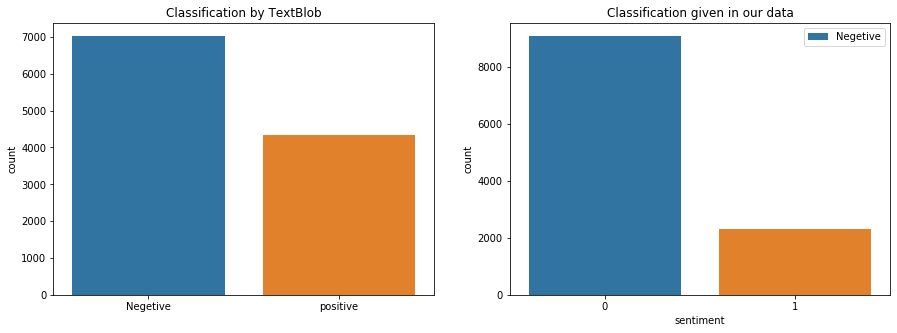

In [ ]:
sentiment=[]
sent_text=[]
for i in df.text:
    sentiment.append(TextBlob(i).sentiment.polarity)
    if TextBlob(i).sentiment.polarity > 0:
           sent_text.append('positive')
#     elif TextBlob(i).sentiment.polarity == 0:
#            sent_text.append('Neutral')
    else:
           sent_text.append('Negetive')
            
fig, ax = plt.subplots(figsize=(15,5), nrows = 1, ncols=2)
sns.countplot(sent_text, ax=ax[0])
sns.countplot(df.sentiment, ax=ax[1])
ax[1].set_title('Classification given in our data')
ax[1].legend(['Negetive', 'Positive'])
ax[0].set_title('Classification by TextBlob')
plt.show()

In [ ]:
############ NLTK VADER

In [ ]:
sentiment=[]

for i in tqdm(df.text):
    sid = SentimentIntensityAnalyzer()
    pol = sid.polarity_scores(i)
    if pol['pos']>=0.2:                   # pos kept at 0.2
        sentiment.append('Positive')
    else:
        sentiment.append('Negetive')

100%|██████████| 11381/11381 [01:14<00:00, 152.36it/s]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


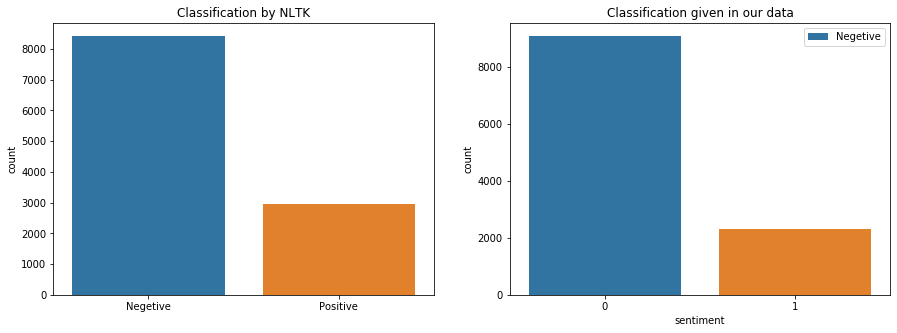

In [ ]:
fig, ax = plt.subplots(figsize=(15,5), nrows = 1, ncols=2)
sns.countplot(sentiment, ax=ax[0])
sns.countplot(df.sentiment, ax=ax[1])
ax[1].set_title('Classification given in our data')
ax[1].legend(['Negetive', 'Positive'])
ax[0].set_title('Classification by NLTK')
plt.show()

# ML Models

## Imports

In [ ]:
# !python -m spacy download en_core_web_lg
# !python -m spacy link en_core_web_lg en
# !pip install xgboost

In [ ]:
import string
import stringprep
from spacy.lang.en import English
from sklearn import metrics
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
import xgboost as xgb
from scipy import stats 
from sklearn.model_selection import KFold
from IPython.display import clear_output
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
punctuations = string.punctuation
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    return mytokens


# df.iloc[0:9500].to_csv('Train.csv', index=False)
# df.iloc[9500:].to_csv('Test.csv', index=False)
Train_part = pd.read_csv('Train.csv') 
Test_part = pd.read_csv('Test.csv')
X_train, X_test, y_train, y_test = Train_part['text'], Test_part['text'], Train_part['sentiment'], Test_part['sentiment']

## XGBoost with TFIDF

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

X_train_ = tfidf_vector.fit_transform(X_train)
X_test_ = tfidf_vector.transform(X_test)

In [ ]:
%%time
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.65),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
kfold_5 = KFold(shuffle = True, n_splits = numFolds)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5,  
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)
clf.fit(X_train_, y_train)

clear_output()

print(clf.best_estimator_)

# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.5556807181497329, gamma=0,
#               gpu_id=-1, importance_type='gain', interaction_constraints='',
#               learning_rate=0.4248798763231012, max_delta_step=0, max_depth=6,
#               min_child_weight=3, missing=nan, monotone_constraints='()',
#               n_estimators=276, n_jobs=8, num_parallel_tree=1, random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#               subsample=0.8196139684354817, tree_method='exact',
#               validate_parameters=1, verbosity=None)
# CPU times: user 12.8 s, sys: 0 ns, total: 12.8 s
# Wall time: 19min 55s

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5556807181497329, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.4248798763231012, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=276, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8196139684354817, tree_method='exact',
              validate_parameters=1, verbosity=None)
CPU times: user 12.8 s, sys: 0 ns, total: 12.8 s
Wall time: 19min 55s


In [ ]:
# Fitting the best model

# clf.fit(X_train_, y_train)

predicted = clf.predict(X_test_)
clear_output()
print("Accuracy:",round(metrics.accuracy_score(y_test, predicted), 2) \
,"Precision:",round(metrics.precision_score(y_test, predicted), 2) \
,"Recall:",round(metrics.recall_score(y_test, predicted), 2))

# Accuracy: 0.87 Precision: 0.76 Recall: 0.57

Accuracy: 0.87 Precision: 0.76 Recall: 0.57


## XGBoost with BOW

In [ ]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

X_train_ = bow_vector.fit_transform(X_train)
X_test_ = bow_vector.transform(X_test)

In [ ]:
%%time
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.65),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
kfold_5 = KFold(shuffle = True, n_splits = numFolds)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)
clf.fit(X_train_, y_train)

clear_output()

print(clf.best_estimator_)

# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.5108143676490189, gamma=0,
#               gpu_id=-1, importance_type='gain', interaction_constraints='',
#               learning_rate=0.015217517715819088, max_delta_step=0, max_depth=6,
#               min_child_weight=1, missing=nan, monotone_constraints='()',
#               n_estimators=628, n_jobs=8, num_parallel_tree=1, random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#               subsample=0.8878847634295339, tree_method='exact',
#               validate_parameters=1, verbosity=None)
# CPU times: user 22.4 s, sys: 0 ns, total: 22.4 s
# Wall time: 14min 6s

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5108143676490189, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.015217517715819088, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=628, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8878847634295339, tree_method='exact',
              validate_parameters=1, verbosity=None)
CPU times: user 22.4 s, sys: 0 ns, total: 22.4 s
Wall time: 14min 6s


In [ ]:
# Fitting the best model

# clf.fit(X_train_, y_train)

predicted = clf.predict(X_test_)
clear_output()
print("Accuracy:",round(metrics.accuracy_score(y_test, predicted), 2) \
,"Precision:",round(metrics.precision_score(y_test, predicted), 2) \
,"Recall:",round(metrics.recall_score(y_test, predicted), 2))

# Accuracy: 0.89 Precision: 0.84 Recall: 0.58

Accuracy: 0.89 Precision: 0.84 Recall: 0.58


## Support Vector Classifier

In [ ]:
from sklearn.svm import SVC

### TFIDF

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

X_train_ = tfidf_vector.fit_transform(X_train)
X_test_ = tfidf_vector.transform(X_test)

In [ ]:
clf = SVC()
param_dist = {'C': stats.randint(1,1000), 
               'gamma': stats.uniform(0.0001,1), 
               'kernel': ['linear', 'rbf']
             }

numFolds = 5
kfold_5 = KFold(shuffle = True, n_splits = numFolds)

clf = RandomizedSearchCV(clf, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)
clf.fit(X_train_, y_train)

clear_output()

clf.best_estimator_

# SVC(C=99, gamma=0.4748831270323305)

SVC(C=99, gamma=0.4748831270323305)

In [ ]:
# Fitting the best model

# clf.fit(X_train_, y_train)

predicted = clf.predict(X_test_)
clear_output()
print("Accuracy:",round(metrics.accuracy_score(y_test, predicted), 2) \
,"Precision:",round(metrics.precision_score(y_test, predicted), 2) \
,"Recall:",round(metrics.recall_score(y_test, predicted), 2))

# Accuracy: 0.91 Precision: 0.83 Recall: 0.71

Accuracy: 0.91 Precision: 0.83 Recall: 0.71


### BOW

In [ ]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
X_train_ = bow_vector.fit_transform(X_train)
X_test_ = bow_vector.transform(X_test)

In [ ]:
clf = SVC()
param_dist = {'C': stats.randint(1,1000), 
               'gamma': stats.uniform(0.0001,1), 
               'kernel': ['linear', 'rbf']
             }

numFolds = 5
kfold_5 = KFold(shuffle = True, n_splits = numFolds)

clf = RandomizedSearchCV(clf, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)
clf.fit(X_train_, y_train)

clear_output()

clf.best_estimator_

# SVC(C=40, gamma=0.017879516682235874)

SVC(C=40, gamma=0.017879516682235874)

In [ ]:
# Fitting the best model

# clf.fit(X_train_, y_train)

predicted = clf.predict(X_test_)
clear_output()
print("Accuracy:",round(metrics.accuracy_score(y_test, predicted), 2) \
,"Precision:",round(metrics.precision_score(y_test, predicted), 2) \
,"Recall:",round(metrics.recall_score(y_test, predicted), 2))

# Accuracy: 0.9 Precision: 0.78 Recall: 0.74

Accuracy: 0.9 Precision: 0.78 Recall: 0.74


### Without Hyperparameter Tuning

In [ ]:
# # TFIDF
# tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

# X_train_ = tfidf_vector.fit_transform(X_train)
# X_test_ = tfidf_vector.transform(X_test)

# clf = SVC()
# clf.fit(X_train_, y_train)
# predicted = clf.predict(X_test_)

# clear_output()
# print("Accuracy:",round(metrics.accuracy_score(y_test, predicted), 2) \
# ,"Precision:",round(metrics.precision_score(y_test, predicted), 2) \
# ,"Recall:",round(metrics.recall_score(y_test, predicted), 2))

In [ ]:
# # BOW
# bow_vector = CountVectorizer(tokenizer = spacy_tokenizer)

# X_train_ = bow_vector.fit_transform(X_train)
# X_test_ = bow_vector.transform(X_test)

# clf = SVC()
# clf.fit(X_train_, y_train)
# predicted = clf.predict(X_test_)

# clear_output()
# print("Accuracy:",round(metrics.accuracy_score(y_test, predicted), 2) \
# ,"Precision:",round(metrics.precision_score(y_test, predicted), 2) \
# ,"Recall:",round(metrics.recall_score(y_test, predicted), 2))

## Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

### TFIDF

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

X_train_ = tfidf_vector.fit_transform(X_train)
X_test_ = tfidf_vector.transform(X_test)

In [ ]:
%%time
clf = MultinomialNB()
param_dist = {'alpha': stats.uniform(0.0, 1.0),
              'fit_prior':[True, False]
             }

numFolds = 5
kfold_5 = KFold(shuffle = True, n_splits = numFolds)

clf = RandomizedSearchCV(clf, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)
clf.fit(X_train_, y_train)

clear_output()

print(clf.best_estimator_)

# MultinomialNB(alpha=0.6448689860767197, fit_prior=False)
# CPU times: user 121 ms, sys: 0 ns, total: 121 ms
# Wall time: 177 ms

MultinomialNB(alpha=0.6448689860767197, fit_prior=False)
CPU times: user 121 ms, sys: 0 ns, total: 121 ms
Wall time: 177 ms


In [ ]:
# Fitting the best model

# clf.fit(X_train_, y_train)

predicted = clf.predict(X_test_)
clear_output()
print("Accuracy:",round(metrics.accuracy_score(y_test, predicted), 2) \
,"Precision:",round(metrics.precision_score(y_test, predicted), 2) \
,"Recall:",round(metrics.recall_score(y_test, predicted), 2))

# Accuracy: 0.89 Precision: 0.76 Recall: 0.71

Accuracy: 0.89 Precision: 0.76 Recall: 0.71


###BOW

In [ ]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
X_train_ = bow_vector.fit_transform(X_train)
X_test_ = bow_vector.transform(X_test)

In [ ]:
%%time
clf = MultinomialNB()
param_dist = {'alpha': stats.uniform(0.0, 1.0),
              'fit_prior':[True, False]
             }

numFolds = 5
kfold_5 = KFold(shuffle = True, n_splits = numFolds)

clf = RandomizedSearchCV(clf, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)
clf.fit(X_train_, y_train)

clear_output()

print(clf.best_estimator_)

# MultinomialNB(alpha=0.5178620218594471, fit_prior=False)
# CPU times: user 112 ms, sys: 0 ns, total: 112 ms
# Wall time: 172 ms

MultinomialNB(alpha=0.5178620218594471, fit_prior=False)
CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 172 ms


In [ ]:
# Fitting the best model

# clf.fit(X_train_, y_train)

predicted = clf.predict(X_test_)
clear_output()
print("Accuracy:",round(metrics.accuracy_score(y_test, predicted), 2) \
,"Precision:",round(metrics.precision_score(y_test, predicted), 2) \
,"Recall:",round(metrics.recall_score(y_test, predicted), 2))

# Accuracy: 0.89 Precision: 0.7 Recall: 0.81

Accuracy: 0.89 Precision: 0.7 Recall: 0.81


### Without Hyperparameter Tuning

In [ ]:
# # TFIDF
# tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

# X_train_ = tfidf_vector.fit_transform(X_train)
# X_test_ = tfidf_vector.transform(X_test)


# clf = MultinomialNB()
# clf.fit(X_train_, y_train)
# predicted = clf.predict(X_test_)

# clear_output()
# print("Accuracy:",round(metrics.accuracy_score(y_test, predicted), 2) \
# ,"Precision:",round(metrics.precision_score(y_test, predicted), 2) \
# ,"Recall:",round(metrics.recall_score(y_test, predicted), 2))

In [ ]:
# # BOW
# bow_vector = CountVectorizer(tokenizer = spacy_tokenizer)

# X_train_ = bow_vector.fit_transform(X_train)
# X_test_ = bow_vector.transform(X_test)


# clf = MultinomialNB()
# clf.fit(X_train_, y_train)
# predicted = clf.predict(X_test_)

# clear_output()
# print("Accuracy:",round(metrics.accuracy_score(y_test, predicted), 2) \
# ,"Precision:",round(metrics.precision_score(y_test, predicted), 2) \
# ,"Recall:",round(metrics.recall_score(y_test, predicted), 2))

# Spacy

In [8]:
import pandas as pd

In [9]:
train_data = pd.read_csv('Train.csv')

In [13]:
# len(train_data)
tr, val = train_data.iloc[0:8000], train_data.iloc[8000:]

In [35]:
import os
if not os.path.exists('train/'):
    os.makedirs('train/')
if not os.path.exists('test/'):
    os.makedirs('test/')
tr.to_csv('train/data.csv', index=False)
val.to_csv('test/data.csv', index=False)

In [ ]:
# !pip install --upgrade pip

In [ ]:
# !pip install cytoolz
# !python -m spacy download en_core_web_lg
# !python -m spacy link en_core_web_lg en_vectors_web_lg

import pandas
import plac
import random
import pathlib
import cytoolz
import numpy
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam
from spacy.compat import pickle
import spacy
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import pandas as pd

In [31]:
class SentimentAnalyser(object):
    @classmethod
    def load(cls, path, nlp, max_length=100):
        
        with (path / "config.json").open() as file_:
            model = model_from_json(file_.read())
        
        with (path / "model").open("rb") as file_:
            lstm_weights = pickle.load(file_)
        
        embeddings = get_embeddings(nlp.vocab)
        model.set_weights([embeddings] + lstm_weights)
        
        return cls(model, max_length=max_length)

    def __init__(self, model, max_length=100):
        self._model = model
        self.max_length = max_length

    def __call__(self, doc):
        
        X = get_features([doc], self.max_length)
        y = self._model.predict(X)
        self.set_sentiment(doc, y)

    def pipe(self, docs, batch_size=1000):
        
        for minibatch in cytoolz.partition_all(batch_size, docs):
            minibatch = list(minibatch)
            sentences = []
            for doc in minibatch:
                sentences.extend(doc.sents)
            Xs = get_features(sentences, self.max_length)
            ys = self._model.predict(Xs)
            for sent, label in zip(sentences, ys):
                sent.doc.sentiment += label - 0.5
            for doc in minibatch:
                yield doc

    def set_sentiment(self, doc, y):
        doc.sentiment = float(y[0])

In [32]:
def get_labelled_sentences(docs, doc_labels):
    
    labels = []
    sentences = []
    
    for doc, y in zip(docs, doc_labels):
        for sent in doc.sents:
            sentences.append(sent)
            labels.append(y)
    return sentences, numpy.asarray(labels, dtype="int32")


def get_features(docs, max_length):
    
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype="int32")
    
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs


def train( train_texts, train_labels, dev_texts, dev_labels, lstm_shape, lstm_settings, lstm_optimizer, batch_size=100, 
           nb_epoch=5, by_sentence=True):

    print("Loading spaCy")
    nlp = spacy.load("en_vectors_web_lg")
    nlp.add_pipe(nlp.create_pipe("sentencizer"))
    
    embeddings = get_embeddings(nlp.vocab)
    model = compile_lstm(embeddings, lstm_shape, lstm_settings)

    print("Parsing texts...")
    train_docs = list(nlp.pipe(train_texts))
    dev_docs = list(nlp.pipe(dev_texts))
    
    if by_sentence:
        train_docs, train_labels = get_labelled_sentences(train_docs, train_labels)
        dev_docs, dev_labels = get_labelled_sentences(dev_docs, dev_labels)

    train_X = get_features(train_docs, lstm_shape["max_length"])
    dev_X = get_features(dev_docs, lstm_shape["max_length"])
    
    model.fit( train_X, train_labels,
               validation_data=(dev_X, dev_labels),
               epochs=nb_epoch,
               batch_size=batch_size, callbacks=[terminate_at, checkpoint])
    
    return model

In [33]:
def get_embeddings(vocab):
    return vocab.vectors.data

def evaluate(model_dir, texts, labels, max_length=100):
    
    nlp = spacy.load("en_vectors_web_lg")
    nlp.add_pipe(nlp.create_pipe("sentencizer"))
    nlp.add_pipe(SentimentAnalyser.load(model_dir, nlp, max_length=max_length))

    correct = 0
    i = 0
    for doc in nlp.pipe(texts, batch_size=1000):
        correct += bool(doc.sentiment >= 0.5) == bool(labels[i])
        i += 1
    
    return float(correct) / i

def read_data(data_dir, limit=0):
    
    dataset=pd.read_csv(data_dir / 'data.csv')
    tweets = dataset['text']
    sentiments = dataset['sentiment']
    sentiments = tf.keras.utils.to_categorical(sentiments, num_classes=2, dtype='float32')
    example=zip(tweets,sentiments)
    example=list(example)
    if limit >= 1:
        example = example[:limit]
    return zip(*example)

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint
def auc_score(y_true, y_pred):
         return tf.py_function(roc_auc_score,(y_true,y_pred),tf.double)
    
checkpoint = ModelCheckpoint(filepath="spacy_model.hdf5", monitor='val_auc_score', \
                             verbose=1, save_best_only=True, mode='max')

val_acc_list=[]
val_auc_list=[]
class terminate_at(tf.keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        auc_ = logs['val_auc_score']
        val_auc_list.append(auc_)
        val_acc_list.append(logs['val_accuracy'])
        if auc_>=0.91:
            self.model.stop_training = True
terminate_at = terminate_at()

def compile_lstm(embeddings, shape, settings): 
    
    model = Sequential()
    
    model.add(Embedding( embeddings.shape[0], embeddings.shape[1], input_length=shape["max_length"],
            trainable=False, weights=[embeddings], mask_zero=True))
    
    model.add(TimeDistributed(Dense(shape["nr_hidden"], use_bias=False)))
    
    model.add(Bidirectional(LSTM(128, recurrent_dropout=settings["dropout"], dropout=settings["dropout"])))
    
    model.add(Dense(50, activation=tf.nn.relu))
    model.add(Dense(10, activation=tf.nn.relu))
    
    model.add(Dense(2, activation="softmax"))
    
    model.compile(optimizer=Adam(lr=settings["lr"]), loss="binary_crossentropy", metrics=['accuracy', auc_score])
    
    return model

def main(model_dir='model_lstm', train_dir=pathlib.Path('train'), dev_dir=pathlib.Path('test'), is_runtime=False,
        nr_hidden=64, max_length=170, dropout=0.5, learn_rate=0.001, nb_epoch=200, batch_size=500, nr_examples=-1):

    model_dir = pathlib.Path(model_dir)
    
    if is_runtime:
        dev_texts, dev_labels = read_data(dev_dir)
        acc = evaluate(model_dir, dev_texts, dev_labels, max_length=max_length)
        print(acc)
    else:
        print("Read data")
        train_texts, train_labels = read_data(train_dir, limit=nr_examples)
        dev_texts, dev_labels = read_data(dev_dir, limit=nr_examples)
        
        train_labels = numpy.asarray(train_labels, dtype="int32")
        dev_labels = numpy.asarray(dev_labels, dtype="int32")
        
        lstm = train(train_texts, train_labels, dev_texts, dev_labels,
                    {"nr_hidden": nr_hidden, "max_length": max_length, "nr_class": 2},
                    {"dropout": dropout, "lr": learn_rate},
                    {},
                    nb_epoch=nb_epoch,
                    batch_size=batch_size,
                    )
        
        weights = lstm.get_weights()
        if not os.path.exists('model_lstm/'):
            os.makedirs('model_lstm/')
        if model_dir is not None:
            with (model_dir / "model").open("wb") as file_:
                pickle.dump(weights[1:], file_)
            with (model_dir / "config.json").open("w") as file_:
                file_.write(lstm.to_json())

main()

Read data
Loading spaCy
Parsing texts...
Epoch 1/200
25/25 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.7970 - auc_score: 0.7229
Epoch 00001: val_auc_score improved from -inf to 0.85124, saving model to spacy_model.hdf5
25/25 [==============================] - 41s 2s/step - loss: 0.4474 - accuracy: 0.7970 - auc_score: 0.7229 - val_loss: 0.3643 - val_accuracy: 0.8382 - val_auc_score: 0.8512
Epoch 2/200
25/25 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8703 - auc_score: 0.8676
Epoch 00002: val_auc_score improved from 0.85124 to 0.88640, saving model to spacy_model.hdf5
25/25 [==============================] - 42s 2s/step - loss: 0.3288 - accuracy: 0.8703 - auc_score: 0.8676 - val_loss: 0.3221 - val_accuracy: 0.8718 - val_auc_score: 0.8864
Epoch 3/200
25/25 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.8815 - auc_score: 0.8889
Epoch 00003: val_auc_score improved from 0.88640 to 0.89912, saving model to spacy_

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(val_auc_list)
plt.plot(val_acc_list)
plt.legend(['AUC Scores', 'Accuracies'])
plt.xlabel('Epochs')
plt.show()

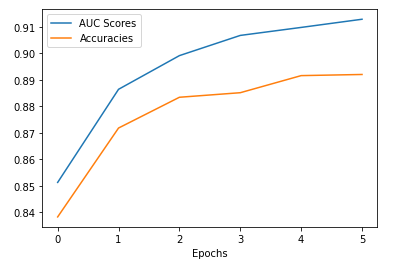

In [50]:
def read_data(data_dir, limit=0):
    
    dataset=pd.read_csv(data_dir +'/data.csv')
    tweets = dataset['text']
    sentiments = dataset['sentiment']
    sentiments = tf.keras.utils.to_categorical(sentiments, num_classes=2, dtype='float32')
    example=zip(tweets,sentiments)
    example=list(example)
    if limit >= 1:
        example = example[:limit]
    return zip(*example)

test_texts, test_labels = read_data('Test', limit=-1)
test_labels = numpy.asarray(test_labels, dtype="int32")

In [51]:
nlp = spacy.load("en_vectors_web_lg")
nlp.add_pipe(nlp.create_pipe("sentencizer"))

embeddings = get_embeddings(nlp.vocab)
test_docs = list(nlp.pipe(test_texts))

test_docs, test_labels = get_labelled_sentences(test_docs, test_labels)

test_X = get_features(test_docs, 170)

In [ ]:
test_data = pd.read_csv('Test/data.csv')

spacymodel = tf.keras.models.load_model("spacy_model.hdf5", compile=False)
spacymodel.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', auc_score])

predictions = spacymodel.predict(test_X)

In [60]:
true = test_labels.argmax(axis=-1)

In [61]:
pred = predictions.argmax(axis=-1) # 0 bad ,1 Good

In [62]:
from sklearn import metrics


print("Accuracy:",round(metrics.accuracy_score(true, pred), 2) \
,"Precision:",round(metrics.precision_score(true, pred), 2) \
,"Recall:",round(metrics.recall_score(true, pred), 2))

# Accuracy: 0.89 Precision: 0.75 Recall: 0.62

Accuracy: 0.89 Precision: 0.75 Recall: 0.62
